## Magnitude distributions for DR2 targets

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import corner as cn
import desitarget.cuts

from astropy.io import fits
from astropy.table import Table
from sklearn.mixture import GaussianMixture
from desitarget.targetmask import desi_mask, bgs_mask

In [3]:
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covariances_, name='covars'))
        hdus.writeto(filename, overwrite=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X

In [4]:
def classify_targets(cuts):
    lrg_targets = cuts['DESI_TARGET'] & desi_mask.LRG
    elg_targets = cuts['DESI_TARGET'] & desi_mask.ELG
    qso_targets = cuts['DESI_TARGET'] & desi_mask.QSO
    bgs_targets = cuts['BGS_TARGET'] & bgs_mask.BGS_BRIGHT
    lrgs = lrg_targets.astype(bool)
    elgs = elg_targets.astype(bool)
    qsos = qso_targets.astype(bool)
    bgs = bgs_targets.astype(bool)
    return cuts[lrgs], cuts[elgs], cuts[qsos], cuts[bgs]


def get_bic(data, components_range):
    bic = []
    #generate bic for each component in the range given
    for comp in components_range:
        model = GaussianMixture(n_components=comp, covariance_type='full')
        model.fit(data)
        bic.append(model.bic(data))
        #print('Component: {:d}'.format(comp))
    return bic

def plot_bic(bic, components_range):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(components_range, np.asarray(np.asarray(bic)/100), marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion/100')
    plt.title('Optimal number of components = {:d}'.format(np.argmin(bic)))
    plt.show()  

def flux_to_mag(data):
    
    gflux = data['DECAM_FLUX'][:,1]
    rflux = data['DECAM_FLUX'][:,2]
    zflux = data['DECAM_FLUX'][:,4]
    w1flux = data['WISE_FLUX'][:,0]
    w2flux = data['WISE_FLUX'][:,1]
    w3flux = data['WISE_FLUX'][:,2]
    w4flux = data['WISE_FLUX'][:,3]
    #only keep non-zero, non-negative flux values to convert to magnitudes
    keep = (gflux > 0) & (rflux > 0) & (zflux > 0) & (w1flux > 0) & (w2flux > 0) & (w3flux > 0) & (w4flux >0)
    gg = 22.5-2.5*np.log10(gflux[keep])
    rr = 22.5-2.5*np.log10(rflux[keep])
    zz = 22.5-2.5*np.log10(zflux[keep])
    w1 = 22.5-2.5*np.log10(w1flux[keep])
    w2 = 22.5-2.5*np.log10(w2flux[keep])
    w3 = 22.5-2.5*np.log10(w3flux[keep])
    w4 = 22.5-2.5*np.log10(w4flux[keep])
    return gg, rr, zz, w1, w2, w3, w4

def make_gmm_model(X_data, components_range, model_filename, seed=123, bic_plot=False):
    #list of bic values for given range of components
    bic = get_bic(X_data, components_range)
    #option to plot bic values
    if bic_plot:
        plot_bic(bic, components_range)
    #index of lowest bic value gives the optimal number of components
    n_comp = np.argmin(bic)
    gen = np.random.RandomState(seed)
    model = GaussianMixture(n_components=n_comp, covariance_type="full", random_state=gen).fit(X_data)
    GaussianMixtureModel.save(model, model_filename)
    print('Saved GMM as {:s}.'.format(model_filename))

In [5]:
def dr2_data(object_data):
    #takes in table data for each object type and returns a numpy array of DECAM/WISE magnitudes
    gg, rr, zz, w1, w2, w3, w4 = flux_to_mag(object_data)
    return np.array([gg, rr, zz, w1, w2, w3, w4]).T

def data_cross_split(object_mag):
    #splits data into training and validation sets
    tot = len(object_mag)
    half = np.floor(tot/2.).astype(int)
    data = object_mag[:half]
    cross = object_mag[half:tot]
    return data, cross

def sample_magnitudes(target_type, n_targets, random_state=None):
    if target_type == 'LRG':
        model = GaussianMixtureModel.load('data/lrgMag_gmm.fits')
    elif target_type == 'ELG':
        model = GaussianMixtureModel.load('data/elgMag_gmm.fits')
    elif target_type == 'QSO':
        model = GaussianMixtureModel.load('data/qsoMag_gmm.fits')
    elif target_type == 'BGS':
        model = GaussianMixtureModel.load('data/bgsMag_gmm.fits')
    return  model.sample(n_targets, random_state)

## Import targets that have passed selection cuts

In [6]:
#import selection dr2 targets that have passed selection cuts
cuts = Table.read('data/all_cuts.fits', format='fits')
lrg, elg, qso, bgs = classify_targets(cuts)

In [7]:
#rng for sampling
seed = 123
gen = np.random.RandomState(seed)

#number of components to test for bic
components_range = range(1,36)

## LRGs

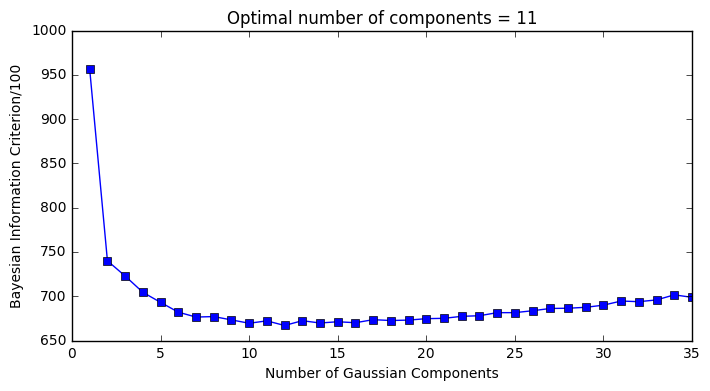

Saved GMM as data/lrgMag_gmm.fits.


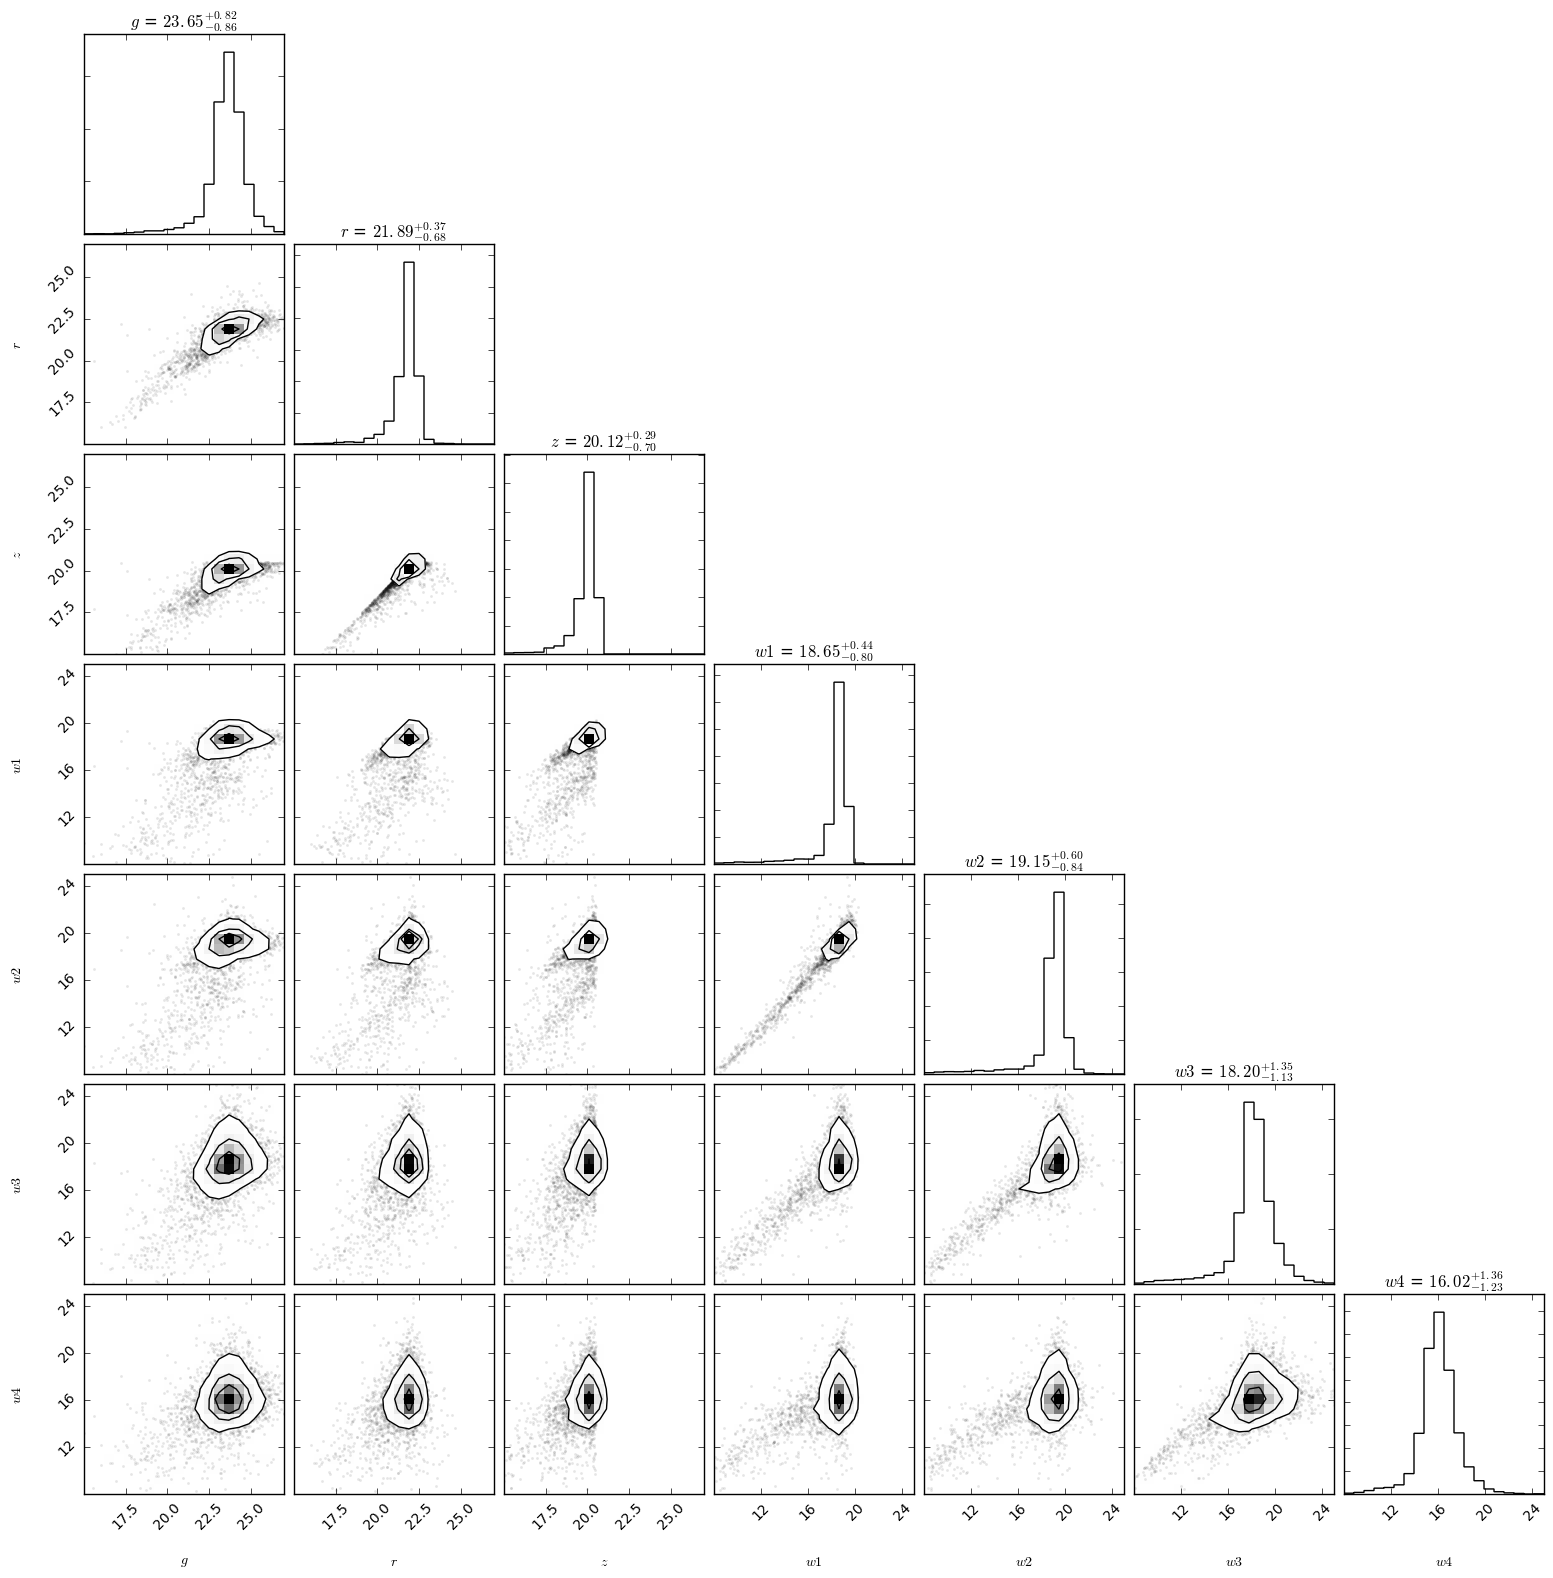

In [8]:
lrgMag = dr2_data(lrg)

#make sure data, sample and cross-validation sets are of same size for comparison
lrgMag_data, lrgMag_cross = data_cross_split(lrgMag)

make_gmm_model(lrgMag_data, components_range, model_filename='data/lrgMag_gmm.fits', 
               bic_plot=True)

lrgMag_sample = sample_magnitudes('LRG', n_targets=len(lrgMag_data), random_state=gen)

axes_range = [(15,27), (15,27), (15,27), (8,25), (8,25), (8,25), (8,25)]

#Data
fig1 = cn.corner(lrgMag_data, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

In [ ]:
#Sample
fig2 = cn.corner(lrgMag_sample, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

In [ ]:
#Cross-validation
fig3 = cn.corner(lrgMag_cross, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

### ELGs

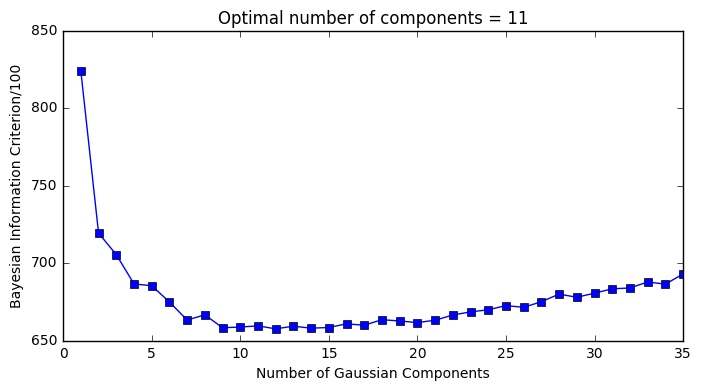

Saved GMM as data/elgMag_gmm.fits.


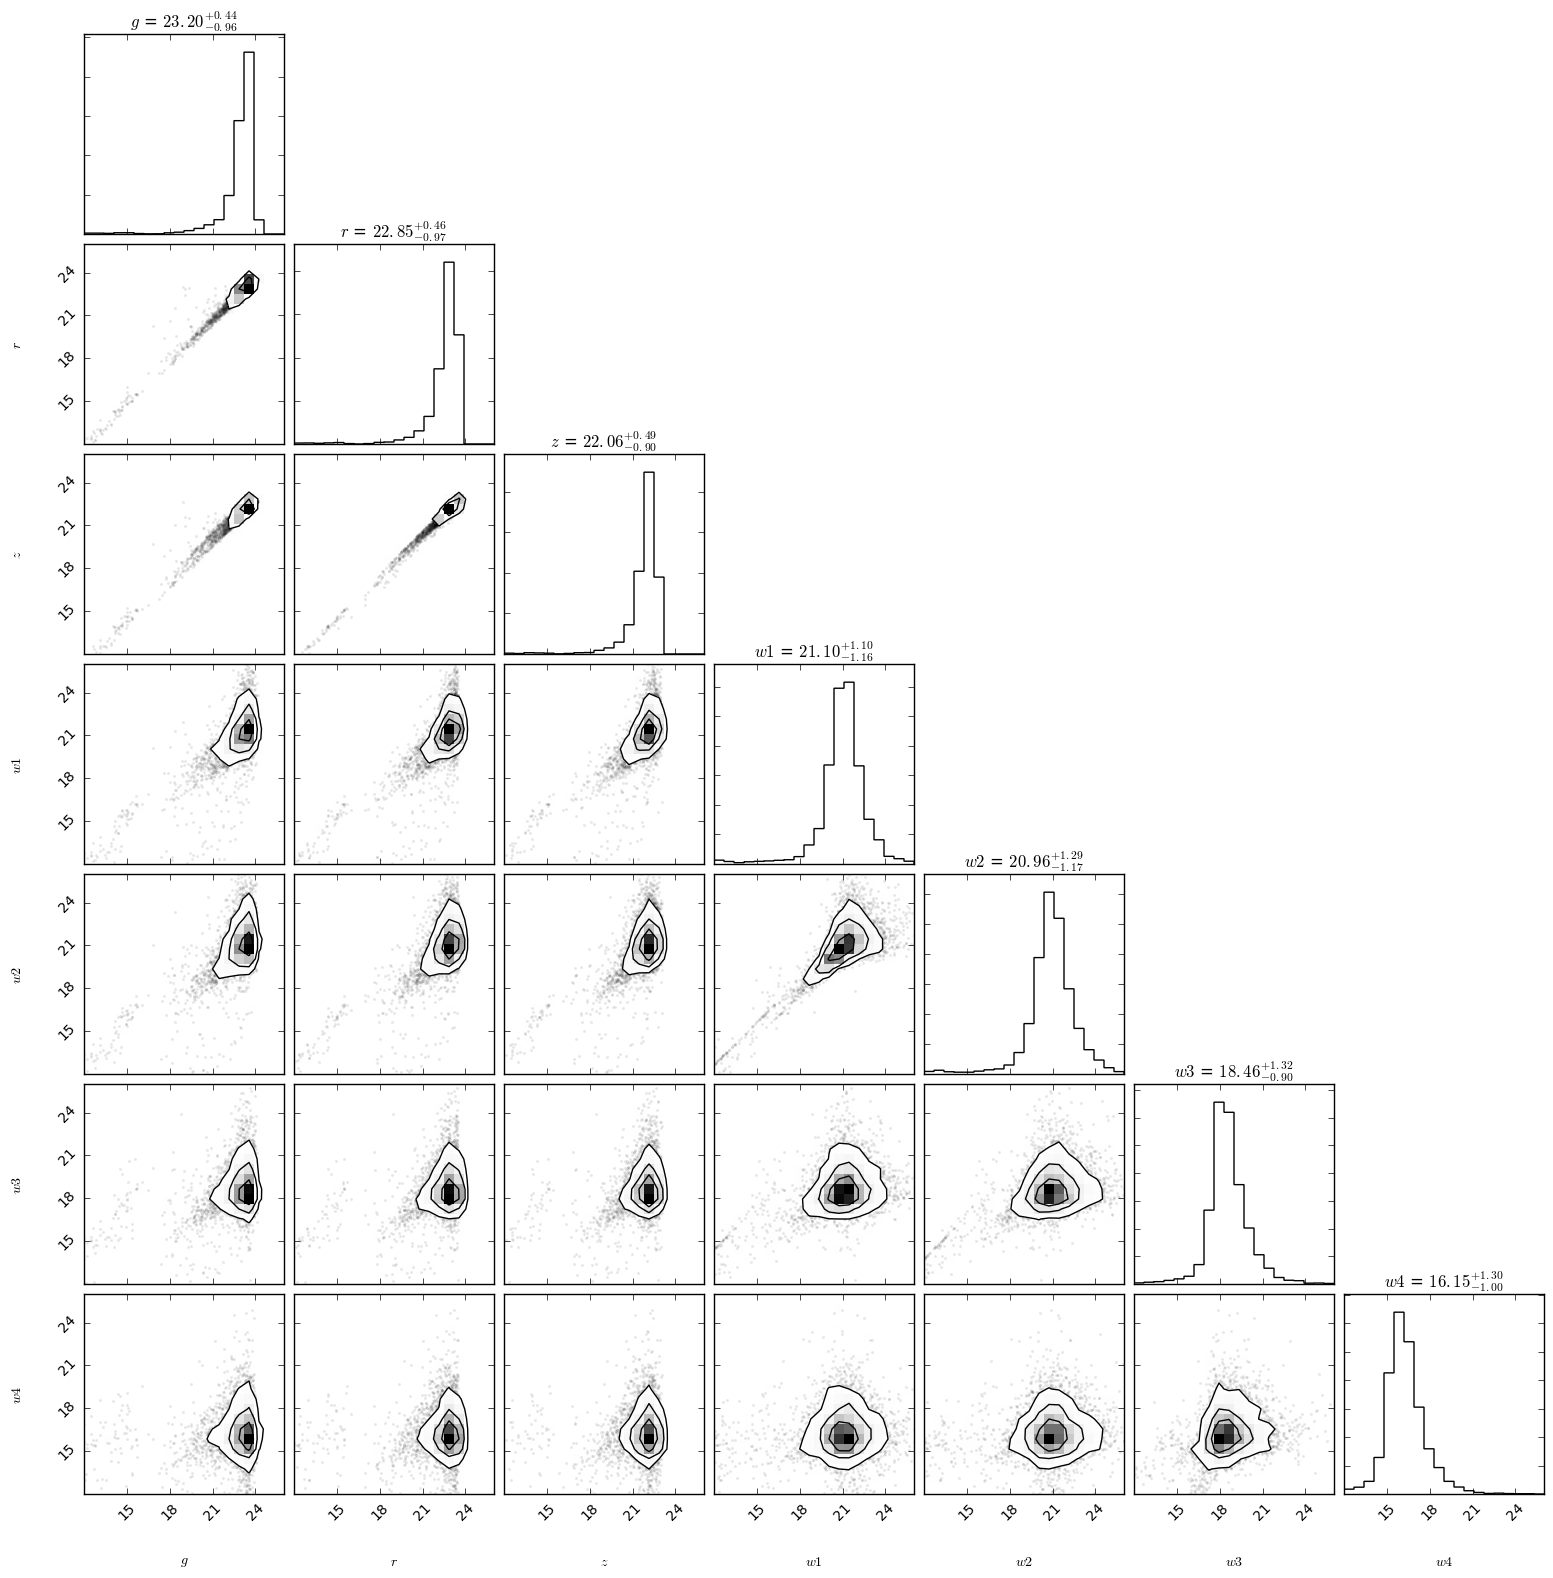

In [9]:
elgMag = dr2_data(elg)
#divide by 3 to make training data sets comparable in size
limit = np.floor(len(elgMag)/3.).astype(int)
elgMag_data, elgMag_cross = data_cross_split(elgMag[:limit])

make_gmm_model(elgMag_data, components_range, model_filename='data/elgMag_gmm.fits', 
               bic_plot=True)

elgMag_sample = sample_magnitudes('ELG', n_targets=len(elgMag_data), random_state=gen)

axes_range = [(12,26), (12,26), (12,26), (12,26), (12,26), (12,26), (12,26)]

#Data
fig1 = cn.corner(elgMag_data, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

In [ ]:
#Sample
fig2 = cn.corner(elgMag_sample, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

In [ ]:
#Cross-validation
fig3 = cn.corner(elgMag_cross, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

### QSOs

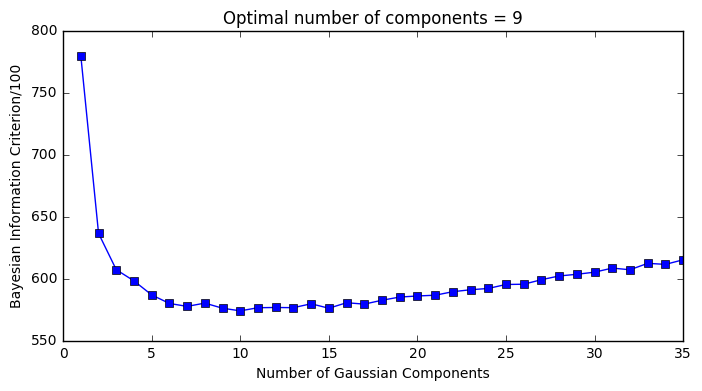

Saved GMM as data/qsoMag_gmm.fits.


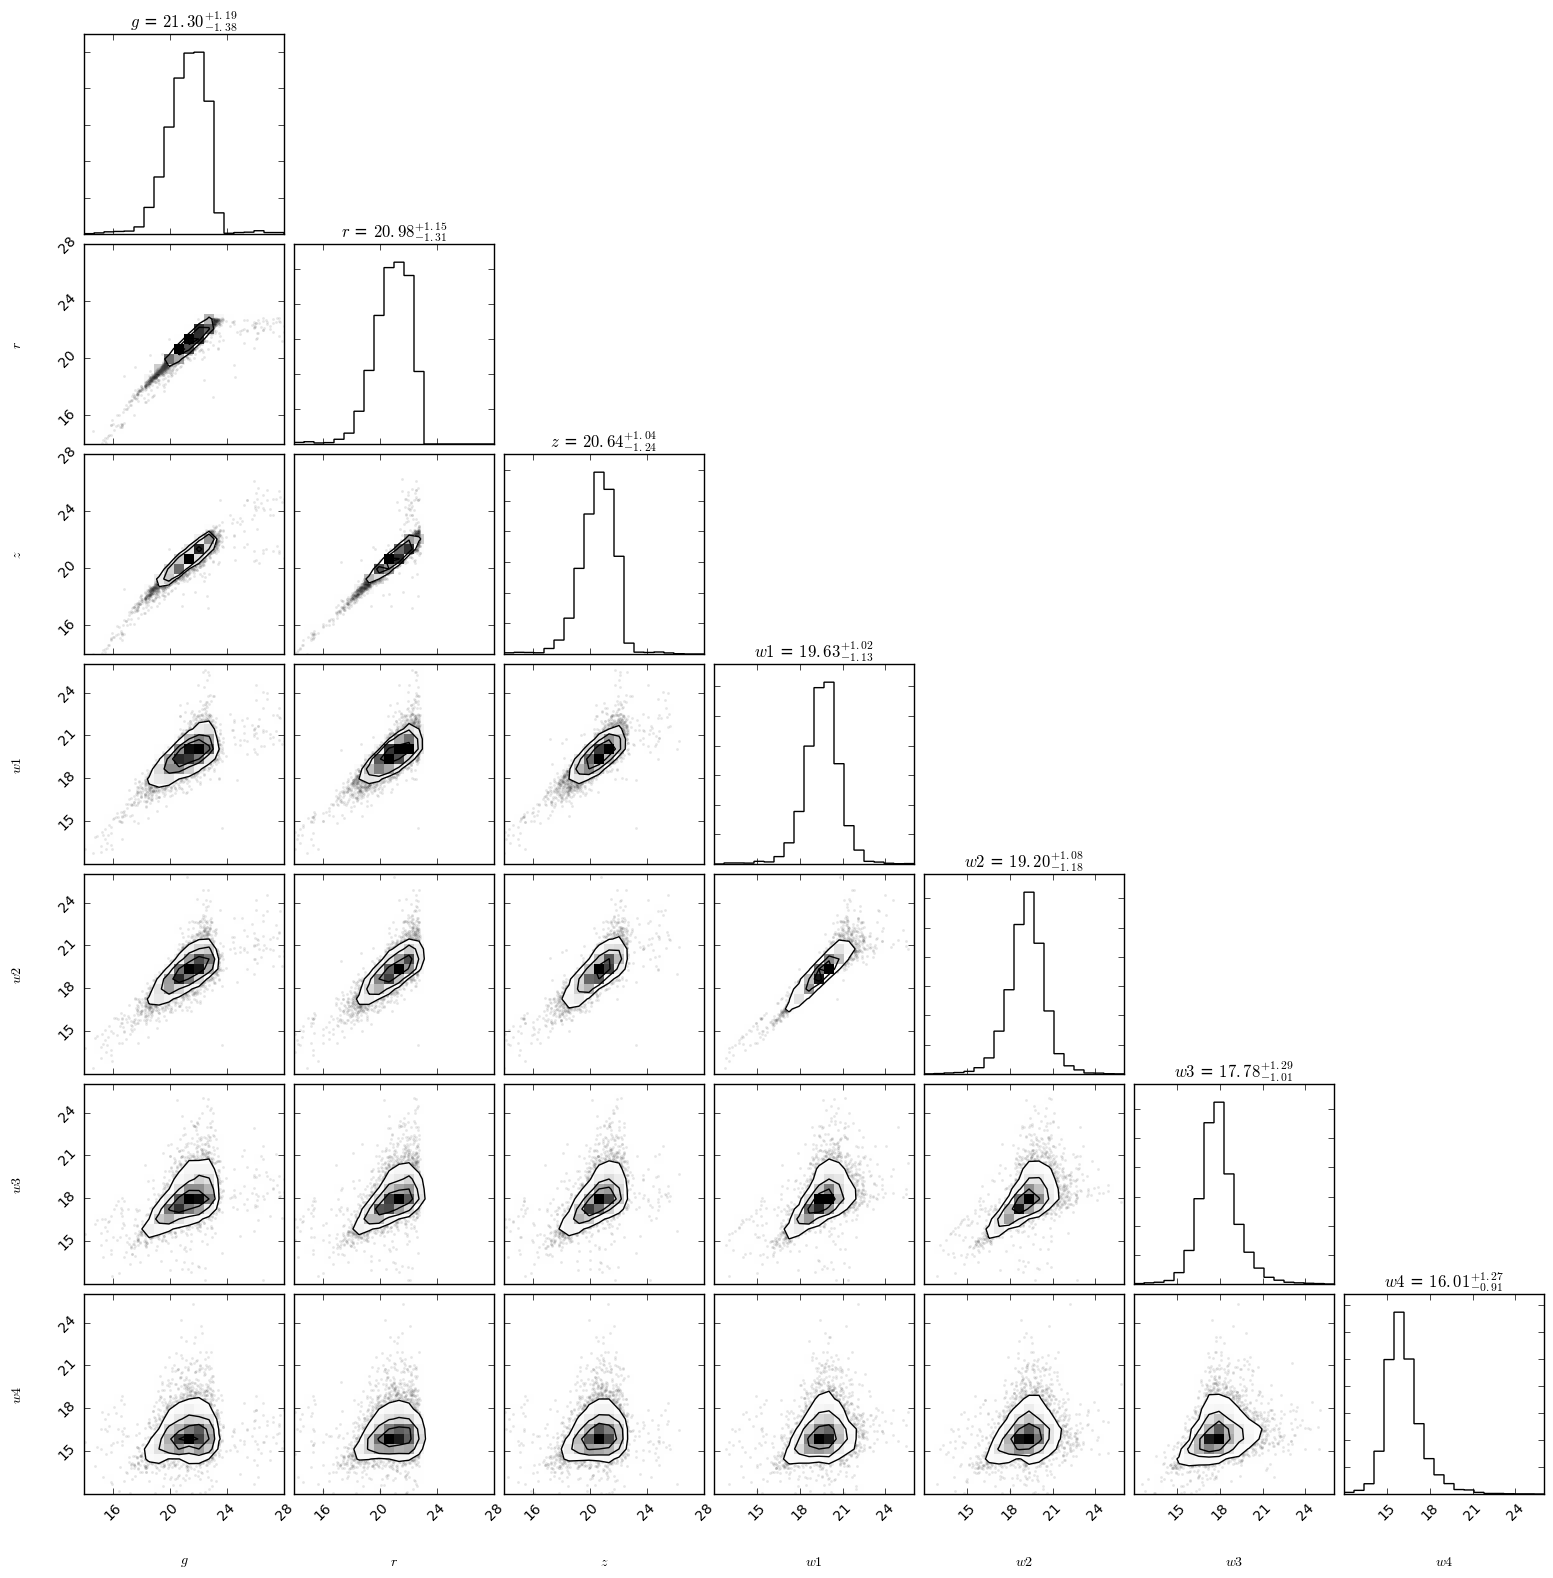

In [10]:
qsoMag = dr2_data(qso)
qsoMag_data, qsoMag_cross = data_cross_split(qsoMag)

make_gmm_model(qsoMag_data, components_range, model_filename='data/qsoMag_gmm.fits', 
               bic_plot=True)

qsoMag_sample = sample_magnitudes('QSO', n_targets=len(qsoMag_data), random_state=gen)

axes_range = [(14,28), (14,28), (14,28), (12,26), (12,26), (12,26), (12,26)]

#Data
fig1 = cn.corner(qsoMag_data, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

In [ ]:
#Sample
fig2 = cn.corner(qsoMag_sample, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

In [ ]:
#Cross-validation
fig3 = cn.corner(qsoMag_cross, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)

### BGS

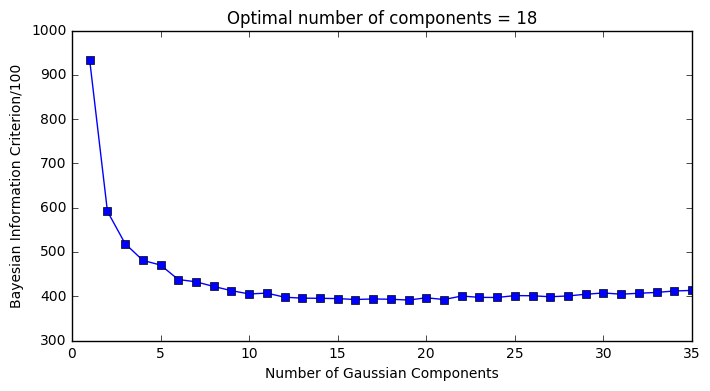

Saved GMM as data/bgsMag_gmm.fits.


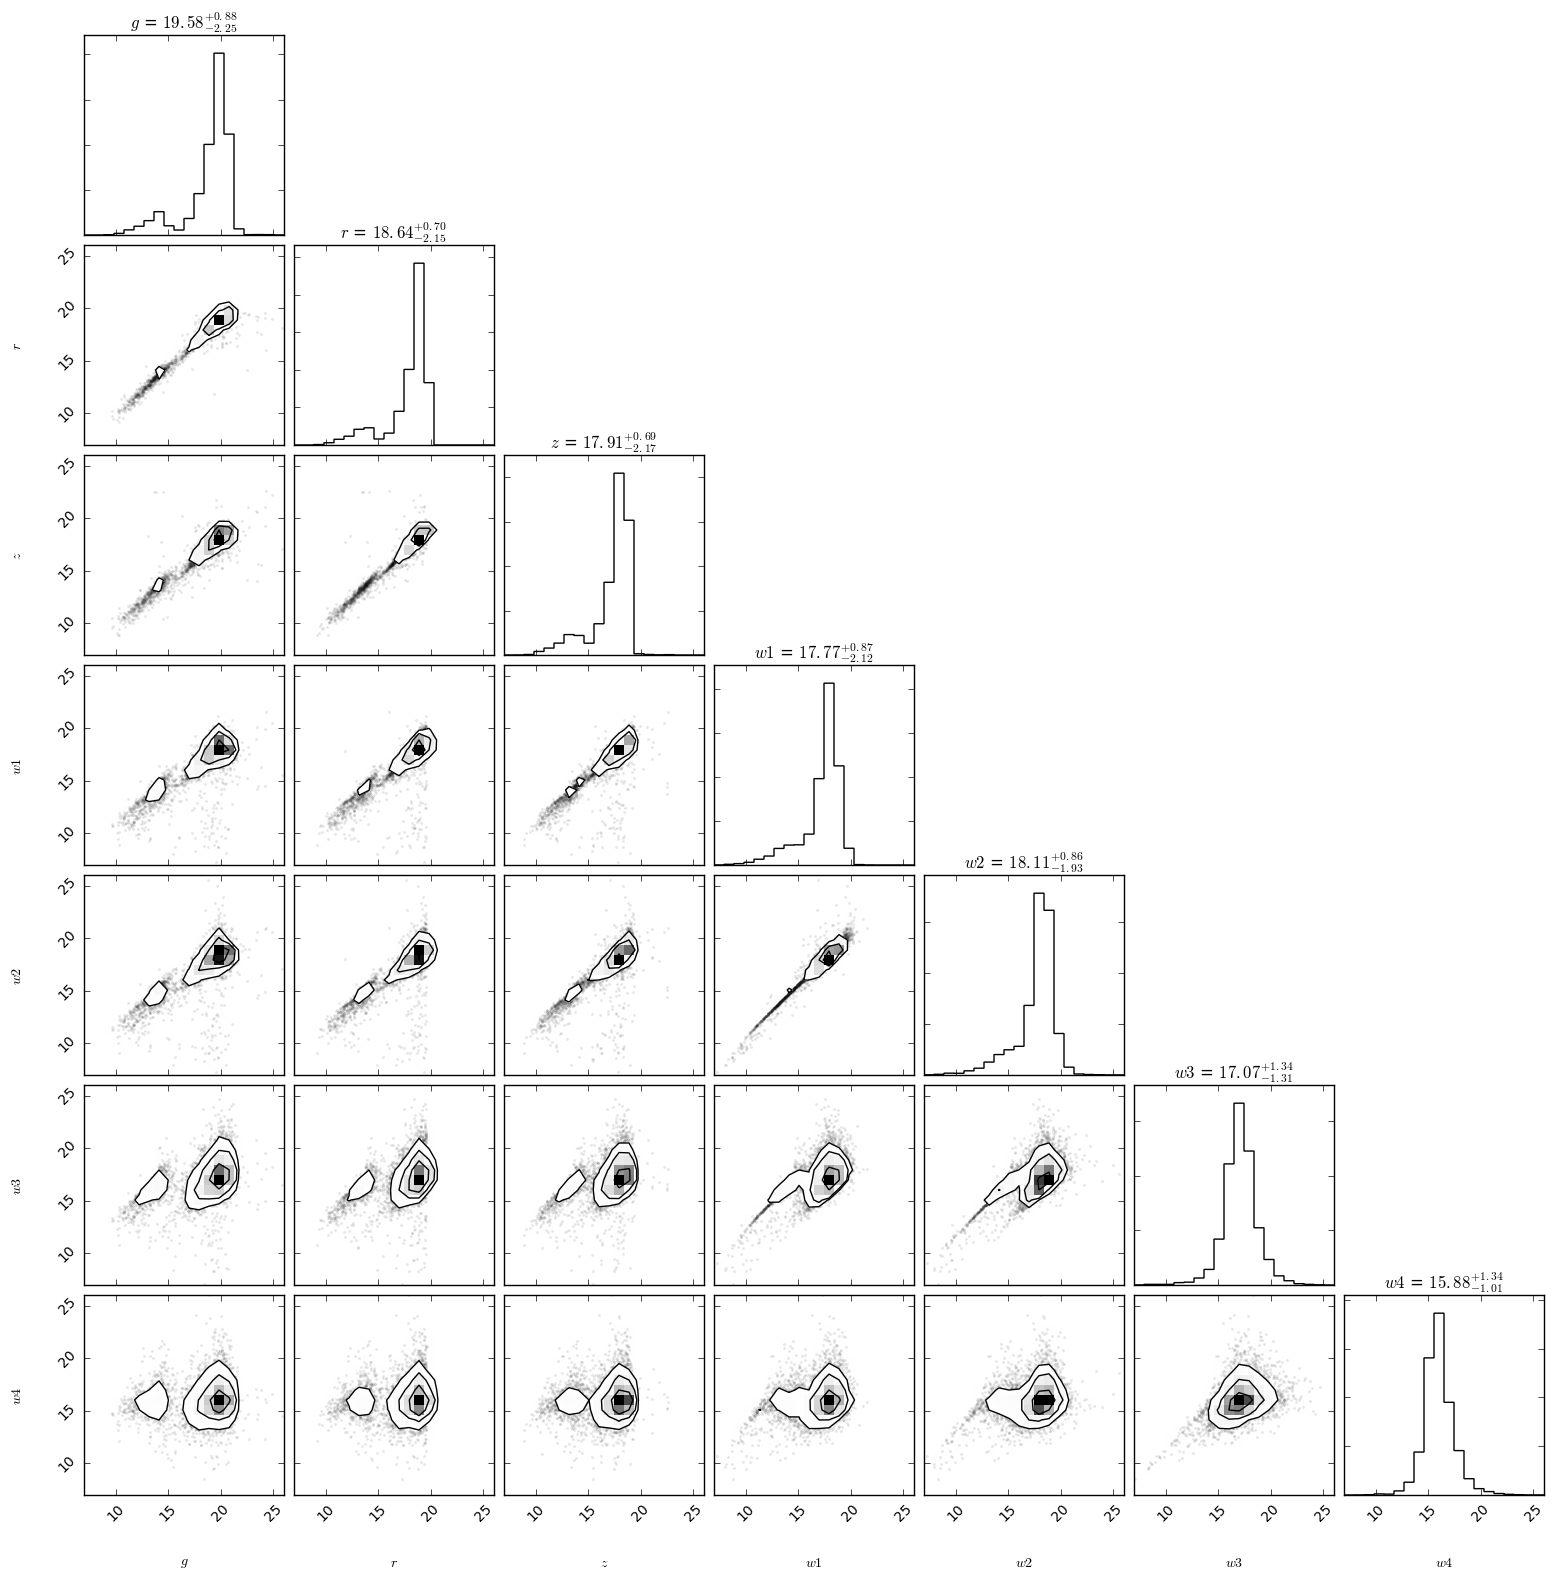

In [11]:
bgsMag = dr2_data(bgs)
limit = np.floor(len(bgsMag)/5.).astype(int)
bgsMag_data, bgsMag_cross = data_cross_split(bgsMag[:limit])

make_gmm_model(bgsMag_data, components_range, model_filename='data/bgsMag_gmm.fits', 
               bic_plot=True)

bgsMag_sample = sample_magnitudes('BGS', n_targets=len(bgsMag_data), random_state=gen)

axes_range = [(7,26), (7,26), (7,26), (7,26), (7,26), (7,26), (7,26)]

#Data
fig1 = cn.corner(bgsMag_data, labels=[r"$g$", r"$r$", r"$z$", r"$w1$", r"$w2$", r"$w3$", r"$w4$"], show_titles=True, 
                 title_kwargs={"fontsize": 12}, range=axes_range)